# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [26]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 0s 0us/step


### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [3]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [4]:
image_raw = tf.io.read_file('/content/koala.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

49152/35363 [=========================================] - 0s 0us/step


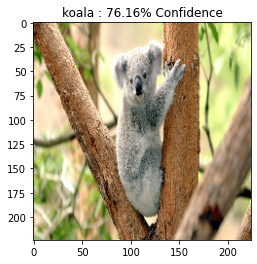

In [5]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

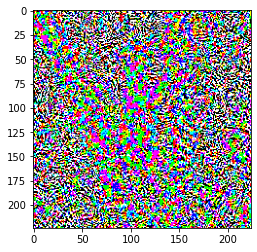

In [7]:
# Get the input label of the image.
koala_index = 105
label = tf.one_hot(koala_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [8]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

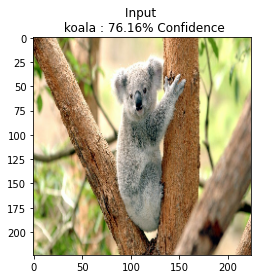

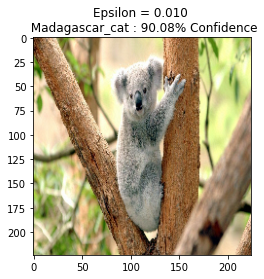

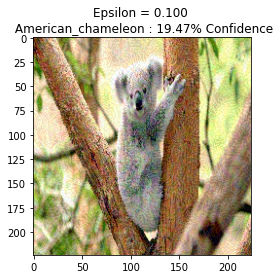

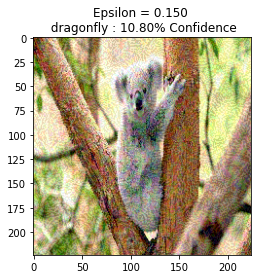

In [9]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [33]:
def fgsm(model, output_list):
  for i in range(len(animals)):
    image_raw = tf.io.read_file(f'/content/{animals[i]}.jpg')
    image = tf.image.decode_image(image_raw)
    image = preprocess(image)
    image_probs = pretrained_model.predict(image)
    _, image_class, class_confidence = get_imagenet_label(image_probs)

    index = animal_index[i]
    label = tf.one_hot(index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))
    perturbations = create_adversarial_pattern(image, label)

    ad_image_class = image_class
    eps = 0
    while image_class == ad_image_class:
      eps = eps + 0.001
      adv_x = image + eps*perturbations
      adv_x = tf.clip_by_value(adv_x, -1, 1)
      _, ad_image_class, class_confidence = get_imagenet_label(model.predict(adv_x))
    
    output_list.append((image_class, ad_image_class, round(eps, 3)))

In [58]:
animals = ['koala', 'panda', 'goldfish', 'tiger', 'shark', 'dog', 'crab', 'nemo', 'cock', 'ostrich']
animal_index = [105, 388, 1, 292, 2, 180, 207, 125, 7, 9]
task2 = list()

fgsm(pretrained_model, task2)

task2

[('koala', 'Madagascar_cat', 0.001),
 ('giant_panda', 'three-toed_sloth', 0.183),
 ('goldfish', 'starfish', 0.16),
 ('tiger', 'tiger_cat', 0.014),
 ('great_white_shark', 'tiger_shark', 0.004),
 ('American_Staffordshire_terrier', 'French_bulldog', 0.001),
 ('hermit_crab', 'stole', 0.304),
 ('anemone_fish', 'coral_reef', 0.213),
 ('cock', 'hen', 0.003),
 ('ostrich', 'black_stork', 0.022)]

In [59]:
task2_df = pd.DataFrame(task2, columns=['correct label','predicted label', 'eps value'])
task2_df

,correct label,predicted label,eps value
0,koala,Madagascar_cat,0.001
1,giant_panda,three-toed_sloth,0.183
2,goldfish,starfish,0.160
3,tiger,tiger_cat,0.014
4,great_white_shark,tiger_shark,0.004
5,American_Staffordshire_terrier,French_bulldog,0.001
6,hermit_crab,stole,0.304
7,anemone_fish,coral_reef,0.213
8,cock,hen,0.003
9,ostrich,black_stork,0.022


# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


In [49]:
mn_list = list()
MobileNet_model = tf.keras.applications.mobilenet.MobileNet(include_top=True,
                                                            weights='imagenet')
MobileNet_model.trainable = False
fgsm(MobileNet_model, mn_list)

mn_df = pd.DataFrame(mn_list, columns=['correct label','predicted label', 'eps value'])
mn_df

,correct label,predicted label,eps value
0,koala,Madagascar_cat,0.055
1,giant_panda,chambered_nautilus,0.314
2,goldfish,starfish,0.238
3,tiger,peacock,0.394
4,great_white_shark,barracouta,0.233
5,American_Staffordshire_terrier,Staffordshire_bullterrier,0.001
6,hermit_crab,peacock,0.556
7,anemone_fish,night_snake,0.213
8,cock,ruffed_grouse,0.060
9,ostrich,badger,0.302


In [50]:
dn121_list = list()
DenseNet121_model = tf.keras.applications.densenet.DenseNet121(include_top=True,
                                                            weights='imagenet')
DenseNet121_model.trainable = False
fgsm(DenseNet121_model, dn121_list)

dn121_df = pd.DataFrame(dn121_list, columns=['correct label','predicted label', 'eps value'])
dn121_df

,correct label,predicted label,eps value
0,koala,Madagascar_cat,0.069
1,giant_panda,badger,0.587
2,goldfish,starfish,0.397
3,tiger,tiger_cat,0.580
4,great_white_shark,coho,0.453
5,American_Staffordshire_terrier,Great_Dane,0.099
6,hermit_crab,chambered_nautilus,0.351
7,anemone_fish,sea_slug,0.068
8,cock,hen,0.034
9,ostrich,Irish_water_spaniel,0.272


In [46]:
dn169_list = list()
DenseNet169_model = tf.keras.applications.densenet.DenseNet169(include_top=True,
                                                            weights='imagenet')
DenseNet169_model.trainable = False
fgsm(DenseNet169_model, dn169_list)

dn169_df = pd.DataFrame(dn169_list, columns=['correct label','predicted label', 'eps value'])
dn169_df

,correct label,predicted label,eps value
0,koala,Madagascar_cat,0.101
1,giant_panda,badger,0.561
2,goldfish,starfish,0.315
3,tiger,lionfish,0.524
4,great_white_shark,barracouta,0.402
5,American_Staffordshire_terrier,Ibizan_hound,0.005
6,hermit_crab,nematode,0.870
7,anemone_fish,miniature_pinscher,0.142
8,cock,hen,0.149
9,ostrich,schipperke,0.456


In [47]:
dn201_list = list()
DenseNet201_model = tf.keras.applications.densenet.DenseNet201(include_top=True,
                                                            weights='imagenet')
DenseNet201_model.trainable = False
fgsm(DenseNet201_model, dn201_list)

dn201_df = pd.DataFrame(dn201_list, columns=['correct label','predicted label', 'eps value'])
dn201_df

82534400/82524592 [==============================] - 1s 0us/step


,correct label,predicted label,eps value
0,koala,Madagascar_cat,0.080
1,giant_panda,badger,0.761
2,goldfish,starfish,0.360
3,tiger,tiger_cat,0.412
4,great_white_shark,puffer,0.532
5,American_Staffordshire_terrier,dingo,0.092
6,hermit_crab,armadillo,0.618
7,anemone_fish,teddy,0.185
8,cock,hen,0.030
9,ostrich,American_black_bear,0.347


In [48]:
nn_list = list()
NasNet_model = tf.keras.applications.nasnet.NASNetMobile(include_top=True,
                                                              weights='imagenet')
NasNet_model.trainable = False
fgsm(NasNet_model, nn_list)

nn_df = pd.DataFrame(nn_list, columns=['correct label','predicted label', 'eps value'])
nn_df

,correct label,predicted label,eps value
0,koala,Madagascar_cat,0.055
1,giant_panda,sea_urchin,0.573
2,goldfish,starfish,0.421
3,tiger,zebra,0.292
4,great_white_shark,hammerhead,0.168
5,American_Staffordshire_terrier,Chihuahua,0.026
6,hermit_crab,chambered_nautilus,0.324
7,anemone_fish,rock_beauty,0.175
8,cock,hen,0.062
9,ostrich,Border_collie,0.242


In [60]:
overall = list()
for i in range(10):
  overall.append((task2[i][0], task2[i][2], mn_list[i][2], dn121_list[i][2], dn169_list[i][2], dn201_list[i][2], nn_list[i][2]))

overall_df = pd.DataFrame(overall, columns=['Image', 'MobileNetV2', 'MobileNet', 'DenseNet121', 'DenseNet169', 'DenseNet210', 'NASNetMobile']).set_index('Image')
overall_df

,MobileNetV2,MobileNet,DenseNet121,DenseNet169,DenseNet210,NASNetMobile
Image,,,,,,
koala,0.001,0.055,0.069,0.101,0.080,0.055
giant_panda,0.183,0.314,0.587,0.561,0.761,0.573
goldfish,0.160,0.238,0.397,0.315,0.360,0.421
tiger,0.014,0.394,0.580,0.524,0.412,0.292
great_white_shark,0.004,0.233,0.453,0.402,0.532,0.168
American_Staffordshire_terrier,0.001,0.001,0.099,0.005,0.092,0.026
hermit_crab,0.304,0.556,0.351,0.870,0.618,0.324
anemone_fish,0.213,0.213,0.068,0.142,0.185,0.175
cock,0.003,0.060,0.034,0.149,0.030,0.062


In [61]:
overall_df2 = overall_df.mean()
overall_df2

MobileNetV2     0.0905
MobileNet       0.2366
DenseNet121     0.2910
DenseNet169     0.3525
DenseNet210     0.3417
NASNetMobile    0.2338
dtype: float64

Some observations:
- Based on the data we observed from the table above, we can see that DenseNet169 is the hardest to break, while MobileNetV2 is the easiest according to their average epsilon value. However, when we examine the table entries closely, we can see that DenseNet210 needs a higher epsilon than DenseNet169, which shows that the noise in the image might cause some unexpected entries such as needing 0.87 for DenseNet169 with the hermit_carb class.
- Based on the descriptions of the models, we are expected to have the model robustness in the following descending order: DenseNet210, DenseNet169, DenseNet121, NASNetMobile, MobileNetV2, MobileNet. However, the image we used for predictions might be not as good as the ones they tested; therefore, there are some differences from the expectations.
- In conclusion, based on the data we collected with 10 images, we can say that DenseNet201 is the most robust among other models.

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 